## 关联规则与Apriori算法

### 零、关联规则
>就是一类元素的组合可以导出另外一个元素

比如对于中文而言，假如一段文本里面出现`蜘`这个字，我们可以认为极有可能这段文本里面含有`蛛`这个字。也就是存在一条关联规则:$(蜘) \rightarrow (蛛)$.
同时，大部分情况下关联规则是对称的也就是存在$(蜘) \rightarrow (蛛)$ 的情况下，也存在关联规则：$(蛛) \rightarrow (蜘)$,所以我们可以把这些同一类的关联规则写作二元组$(蜘,蛛)$ .

关联规则挖掘算法就是从数据集中寻找这些关联规则，不过值得注意的是，关联规则只能说明一种概率，也就是**从左边有可能推导出右边**。我们只关心那些可能性大的关联规则。

衡量关联规则性能的指标有两种，支持度和置信度。支持度就是在数据集里面出现这条规则的概率（或次数），显然我们有理由相信，出现次数多的关联规则肯定比较有用。置信度就是衡量这条关联规则正确的几率，比如在中文中`(我，的）` 的支持度肯定比`（蜘，蛛）`这一条关联规则大，但是出现`我`这个字后面是`的`的几率肯定比`蜘`后面出现`蛛`的几率小得多。所以我们说`（蜘，蛛）`的置信度比`(我，的）` 高。

### 一、Apriori算法
我们不可能关心所有可能出现的关联规则，只能找一些比较有用的关联规则来进行分析。当我们使用支持度当作衡量指标的话，就是寻找支持度大于某个特定值的所有关联规则，这个特定值称作**最小支持度**。

我们的关联规则都可以写成元素组合起来的元组的形式，长度从1到元素个数，也就是元素集的真子集。显然有$2^n-1$个，我们一个一个计算是不可能的，Apriori算法使用两个启发规则进行剪枝：

>我们把支持度大于最小支持度的项组合叫做**频繁项集**，反之叫做**非频繁项集**。

* 1.频繁项集的所有子集都为频繁项集
* 2.包含非频繁项集的所有集合都是非频繁项集

先从第一级的项集开始计算，去除所有的非频繁项集，然后根据剩下的频繁项集生成下一级的候选项集（也就是有可能的频繁项集的项集）。然后重复，直到候选项集为零。

### 二、算法步骤
>这里只计算支持度

算法的目标是找出出现概率大于最小支持度的各个子项集，分为两步。
* 1.使用上一级的频繁项集生成下一级的候选项集
* 2.计算各个候选项集的支持度，找到大于最小支持度的所有项集，作为这一级的频繁项集

第二步理论上每一个输入数据集的每一个都要判断和计算一次，复杂度为$O(n)$.不过，当数据稀疏时，可先对数据进行分桶，利用空间换时间。时间复杂度可压缩到$(\frac{n}{m})$，m为项目类型的数量。不过假如数据十分不平均，在特殊条件下性能也会恶化，可加上一步启发步骤，先根据项在数据集的总数量进行排序，每次取出现最小次数的项目类型的那一个桶。这样无论数据分布情况如何，除了一种特殊情况（全部数据集的内容都一样），平均计算时间也小于$O(n)$.
第一步教材里面使用一个简单的规则进行剪枝，实现起来较为复杂，我选用了另外的一种剪枝算法，虽然效果没教材里面的好，但是实现起来较简单，加上过滤步骤，基本上可以去掉绝大多数无用的项集。不过对于特殊情况下性能会很差，但是基本上实际数据不会遇见的。

教材里C++版本的代码应该是不熟悉编程的人写的，看不下去。下面是用python的代码实现，取支持度的代码还是原始的，没有进行分桶，以后再优化吧：

In [2]:
import numpy as np
import pandas as pd

def cmp(a,b):
    if(len(a)!=len(b)):
        return False;
    for i in range(len(a)):
        if(a[i]!=b[i]):
            return False
    return True
def newcombin(oldCombins):
    """
    生成下一级的项集，优化得不彻底,复杂度应该是nlogn的，n为类型数量
    原始论文说这个步骤的最优复杂度应该是n，
    """
    ## 取上一次项集出现的所有项类型，注意不需要使用数据集的所有项类型，
    ## 因为上一次没出现，这一次肯定不会出现的
    items=np.unique(oldCombins.flatten()) 
    maxn=len(oldCombins)
    if maxn>1:
        for i in range(maxn-1): 
            #最后一项不用理的，因为没有比他字典序大的了
            if( not cmp(oldCombins[i][:-1],oldCombins[i+1][:-1])):
                continue; 
                #前后两个的前面部分不一样，那么这个肯定没有办法组合新的
                #对于一个稀疏的数据，这一步就去掉绝大部分的不可能的情况了
            old=oldCombins[i]
            #拿所有可能的类型和它组合，不要判断能不能组合，
            #不然复杂度可能会变大的，虽然有漏网之鱼，但是计算支持度就会被去掉的
            
            #只要保证有序就行
            maxc=max(old)
            for i in items:
                if(i >maxc):
                    res=tuple(old)+(i,)
                    yield res


In [3]:
def apriori(df,minsupport):
    X=df.values
    
    ## 1. 先统计项集大小为1的数据
    #也就是数量除以总数据量
    sup1 = (np.sum(X, axis=0) / float(X.shape[0]))
    
    ##下面两个字典做缓存和输出用的
    ##保存所有支持度，key是项集大小
    allsup={1:sup1[sup1>minsupport]}
    ##保存所有项集
    allitems={1:np.arange(X.shape[1])[sup1>minsupport].reshape(-1,1)}
    
    ## 2.迭代
    
    level=1#第几轮迭代
    count=X.shape[0]## 总数据量
    
    ## 开始迭代
    while True:
        #临时保存的
        tempitems=[]
        tempsup=[]
        
        #取新的项组合
        combin=newcombin(allitems[level])
        
        #对每一个新的项计算支持度，并存到临时表里面去
        for c in combin:
            item=X[:, c].all(axis=1)
            sup=item.sum()/count
            if(sup>minsupport): #剪枝
                tempitems.append(c)
                tempsup.append(sup)
        #加到总字典里面，如果没有就退出
        if len(tempitems)>0:
            level=level+1
            allsup[level]=np.array(tempsup)
            allitems[level]=np.array(tempitems)
        else:
            break;
        
    #3.压平数据，处理成返回值的形状
    
    res=[]
    
    #现在数据形状是存放在dict里面的（level,2,*)
    #先处理成元素为DataFrame的（level,*,2)数组
    for k in sorted(allitems):
        s=pd.Series(allsup[k])
        i=pd.Series([frozenset(i) for i in allitems[k]])
        #r的形状是（该级别项集数量，2）
        r=pd.concat((s,i),axis=1)
        #对每个级别先压入数组
        res.append(r)
    
    #压平第一维，形状变成（所有项集数量，2）
    res_df = pd.concat(res)
    
    #修饰一下，增加可读性
    res_df.columns = ['support', 'itemsets']
    
    #使用列名称输出，比用列号直观
    mapping = {idx: item for idx, item in enumerate(df.columns)}
    res_df['itemsets'] = res_df['itemsets'].apply(lambda x: frozenset([
                                                      mapping[i] for i in x]))
    res_df = res_df.reset_index(drop=True)
    return res_df

### 三、测试与实例

#### 1.简单的数据
下面是一组商店的购买数据，先将其弄成01矩阵

In [4]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder

dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,Apple,Corn,Dill,Eggs,Ice cream,Kidney Beans,Milk,Nutmeg,Onion,Unicorn,Yogurt
0,False,False,False,True,False,True,True,True,True,False,True
1,False,False,True,True,False,True,False,True,True,False,True
2,True,False,False,True,False,True,True,False,False,False,False
3,False,True,False,False,False,True,True,False,False,True,True
4,False,True,False,True,True,True,False,False,True,False,False


使用apriori 算法计算大于0.41的项集

In [8]:
apriori(df, minsupport=0.41)

,support,itemsets
0,0.8,(Eggs)
1,1.0,(Kidney Beans)
2,0.6,(Milk)
3,0.6,(Onion)
4,0.6,(Yogurt)
5,0.8,"(Kidney Beans, Eggs)"
6,0.6,"(Onion, Eggs)"
7,0.6,"(Milk, Kidney Beans)"
8,0.6,"(Kidney Beans, Onion)"
9,0.6,"(Kidney Beans, Yogurt)"


#### 2. 教材的数据集

In [9]:
dataset2 = [['I1','I2','I5'],
            ['I2','I4'],
            ['I2','I3'],
            ['I1','I2','I4'],
            ['I1','I3'],
            ['I2','I3'],
            ['I1','I3'],
            ['I1','I2','I3','I5'],
            ['I1','I2','I3']]

In [10]:
te = TransactionEncoder()
te_ary = te.fit(dataset2).transform(dataset2)
df = pd.DataFrame(te_ary, columns=te.columns_)
apriori(df, minsupport=0.2)

,support,itemsets
0,0.666667,(I1)
1,0.777778,(I2)
2,0.666667,(I3)
3,0.222222,(I4)
4,0.222222,(I5)
5,0.444444,"(I1, I2)"
6,0.444444,"(I1, I3)"
7,0.222222,"(I5, I1)"
8,0.444444,"(I2, I3)"
9,0.222222,"(I4, I2)"


可以看到结果和教材内的示例一样，至少说明我们的算法没有错误：）

#### 3. 大型商店购物数据

下面是一个从网上找到的某商店一年的订单数据

In [11]:
dataxlsx=pd.read_excel(r"D:\workplace\DMML\learn\apriori\Online Retail.xlsx")

In [16]:
dataxlsx.shape

(541909, 8)

一共54w左右，看下内容

In [21]:
dataxlsx.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


我们现在只要知道，第一列是订单id，第二列的商品id。

我们按订单id分组，生成和上面手动输入的数据集一样的数据结构

In [22]:
gp_invoiceno = dataxlsx.groupby('InvoiceNo')
transactions = []
for name,group in gp_invoiceno:
    transactions.append(list(group['StockCode'].map(str)))

生成01矩阵，送入apriori。不过，这个数据集比上面的数据最大不同就是多，所以支持度不再是0.1，0.2那么大的了，这里我们寻找支持度大于0.025的项集。

In [23]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
resres=apriori(df, minsupport=0.025)

我们关心一下项集大小大于1的项集

In [24]:
resres[resres["itemsets"].map(len)>1]

,support,itemsets
114,0.025019,"(20727, 20725)"
115,0.025598,"(20725, 22383)"
116,0.028301,"(85099B, 21931)"
117,0.032162,"(85099B, 22386)"
118,0.026371,"(85099B, 22411)"
119,0.030270,"(22699, 22697)"


下面做一些好玩的，看下支持度的分布情况
我们寻找支持度大于0.01的
>注意这样会花费很久的时间

In [25]:
outt=apriori(df, minsupport=0.01)

看下大小

In [26]:
len(outt)

1076

In [27]:
import matplotlib.pyplot as plt

排序，画图

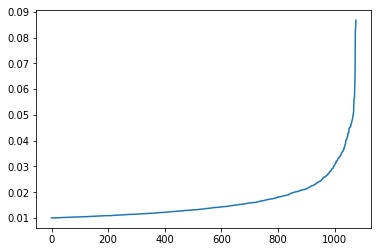

In [28]:
import math
plt.plot(sorted(outt["support"]))

可以看到支持度越大数量越少，大概呈指数形式，具体服从什么分布看不出来。

#### 4.微信聊天数据
下面是微信的文本信息数据，每一行就是一条文本信息

In [31]:
text_filename=r"D:\workplace\wechattool\1.csv"
infile=open(text_filename,encoding='UTF-8')

In [32]:
textlist=[i for i in infile.readlines()]

解析，分词。我这里的分词直接分成单字

In [29]:
def tolists(strs):
    res=[]
    for i in strs:
        if(i=='\n'):
            continue
        res.append(i)
    return res

**载入这个数据集就遇到我们算法的一个小问题**，我们的数据量实在是太大了：）

我们的算法是没有考虑内存使用情况的，笔记本16G内存在运算的过程中满了：）
为了能够运行，我们只截取前面20w的数据

In [43]:
textdict=[]
for i in range(200000):
    textdict.append(tolists(textlist[i]))

In [44]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
oht_ary = te.fit(textdict).transform(textdict, sparse=True)
df = pd.DataFrame(oht_ary, columns=te.columns_, default_fill_value=False)

, ,,,,,,,!,"""",#,...,🤕,🤗,🤢,🤣,🤦,🤪,🤷,🥓,🥚,🧀
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
apriori(df, min_support=0.025, use_colnames=True)

,support,itemsets
0,0.053625,( )
1,0.033140,(1)
2,0.038845,(@)
3,0.057485,([)
4,0.057485,(])
5,0.033840,( )
6,0.037115,(。)
7,0.073725,(一)
8,0.031020,(上)
9,0.031955,(下)


分析结果：
* 1.可以看到“我”这个字出现几率为14%，也就是说每100条消息，出现我字的有14条
* 2.长度为二的项集最高是 \[ 和 \]，是因为微信里面的某些表情使用这两个包裹起来的。比如\[机智\] 这样的，所以这两个在一起出现的几率大
* 3.“不是”，“我的”，“是的” 这样的二字词出现的几率也很大
